<a href="https://colab.research.google.com/github/housleyn/541-hw-7/blob/main/DeepONet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch.nn as nn
import torch
import numpy as np

from matplotlib import pyplot as plt
from torch.optim import Adam
import torch
torch.cuda.is_available()

True

In [3]:
class MLP(nn.Module):
  def __init__(self, in_features : int, out_features: int, hidden_features: int, num_hidden_layers: int) -> None:
    super().__init__()

    self.linear_in = nn.Linear(in_features, hidden_features) #inputs changed to latent space
    self.linear_out = nn.Linear(hidden_features, out_features)#latent space changed to outputs

    self.activation = torch.tanh
    self.layers = nn.ModuleList([self.linear_in] + [nn.Linear(hidden_features, hidden_features) for _ in range(num_hidden_layers)  ]) #creates the rest of the architecture based on number of hidden layers

  def forward(self,x):
      for layer in self.layers:
        x = self.activation(layer(x)) #this effectively finishes the sequential layers function
      return self.linear_out(x)

class DeepONet(nn.Module):
  def __init__(self, latent_features, out_features, branch, trunk) -> None:
    super().__init__()
    self.branch = branch
    self.trunk = trunk
    self.fc = nn.Linear(latent_features, out_features, bias = False) #fully connected. this allows to learn a weighted sum after element wise fusion.

  def forward(self, y, u):
    return self.fc(self.trunk(y)*self.branch(u))


In [4]:
Onet = DeepONet(75, 1, branch = MLP(100, 75, 75, 4), trunk = MLP(1,75,75,4)) #all latent features must be equal (all 75 in this case)

u = torch.rand((2,1,100))
y = torch.rand((2,40,1))

xx = Onet.trunk(y)
tt = Onet.branch(u)

Onet(y,u).shape #[2,40,1] batch size, query points, output_dimension

torch.Size([2, 40, 1])

In [5]:
from numpy.polynomial.chebyshev import Chebyshev,chebval,chebint,cheb2poly
def random_chebyshev(n,M,degree,return_coeff = False):
    '''
    This generates a random function output between the domain [-1,1] along a uniform grid of size n using chebyshev polynomials.
    '''
    coeff = (np.random.rand(degree+1)-0.5)*2*np.abs(M)
    x= np.linspace(-1,1,n)
    y = chebval(x,coeff)
    if return_coeff:
        return x,y,coeff
    else:
        return x,y

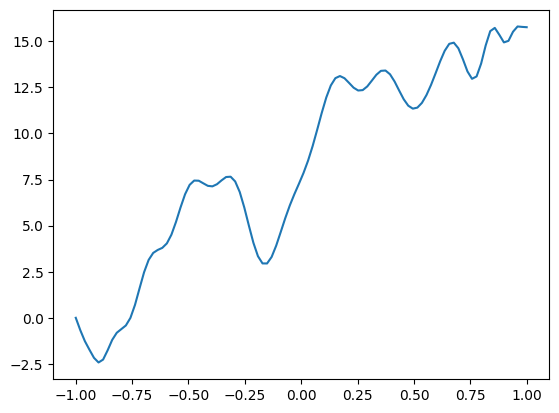

In [6]:
from scipy.integrate import cumulative_trapezoid
x,y,coeff = random_chebyshev(100,10,30,return_coeff= True)

y_int = cumulative_trapezoid(y,x,initial = 0)

plt.plot(x,y_int)

In [7]:
# Generate DataTuples:
def generate_data(n_samples,a,b,n_sensors,n_points,M,degree,y0 = 0,random_query = False,seed = 1234):
    '''
    Generate Data needed for training.

    Returns a tuple of (y,u,Guy) that will be added to the Dataloader
    '''
    if seed is not None:
        np.random.seed(1234)

    x = np.linspace(-1,1,n_points)
    u,dy_coeff = zip(*[random_chebyshev(n_sensors,M,degree,return_coeff=True)[1:] for _ in range(n_samples)])

    u = np.stack(u,axis = 0)

    #Generate 100 y points for -1 and 1

    xp = np.linspace(a,b,n_sensors)
    if random_query:
        y = np.random.rand(n_samples,n_points)*(b-a)+a
    else:
        # y = np.array([np.linspace(a,b,n_points) for _ in range(n_samples)]
        y = np.tile(np.linspace(a,b,n_points),(n_samples,1))

    #Integrate cheb poly, we use interp in case we want random y points
    Guy = [cumulative_trapezoid(dy,xp,initial=y0) for dy in u]
    Guy = [np.interp(yy,xp,G) for yy,G in zip(y,Guy)]

    #Guy data needs 2 batch dimensions: One for samples and the other for
    y,u,Guy = torch.tensor(y,dtype = torch.float32),torch.tensor(u,dtype = torch.float32),torch.tensor(Guy,dtype = torch.float32)
    #To match network shape input and output, need to add a tensor dimension to y and Guy
    return y.unsqueeze(-1),u.unsqueeze(1),Guy.unsqueeze(-1)

In [8]:
ys,us,Guys = generate_data(100,0,2,100,100,5,20)
ys.shape,us.shape,Guys.shape

<ipython-input-7-1a4e64025283>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  y,u,Guy = torch.tensor(y,dtype = torch.float32),torch.tensor(u,dtype = torch.float32),torch.tensor(Guy,dtype = torch.float32)


(torch.Size([100, 100, 1]),
 torch.Size([100, 1, 100]),
 torch.Size([100, 100, 1]))

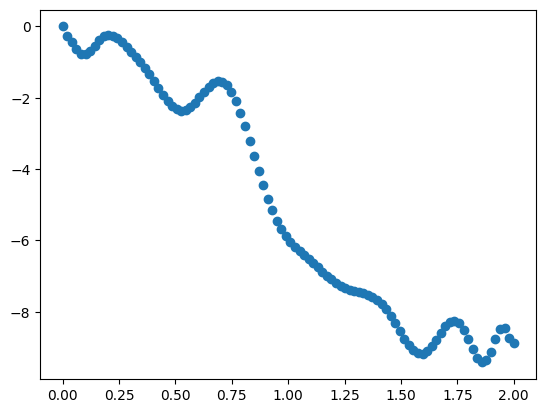

In [9]:
x = np.linspace(0,2,100)

plt.scatter(ys[2].squeeze(),Guys[2].squeeze())

In [10]:
from torch.utils.data import DataLoader, Dataset
class Onet_dataset(Dataset):
  def __init__(self,y,u,Guy):
    self.y = y
    self.u = u
    self.Guy = Guy
  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    return self.y[idx],self.u[idx],self.Guy[idx]


In [11]:
# 1. Generate data
ys, us, Guys = generate_data(10000, 0, 2, 100, 90, 5, 20)
Onet_data = Onet_dataset(ys, us, Guys)

# 2. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Model to device
Onet = DeepONet(75, 1, branch=MLP(100, 75, 75, 4).to(device), trunk=MLP(1, 75, 75, 4).to(device)).to(device)

# 4. DataLoader (data is moved to device in the training loop, not here)
Onet_DL = DataLoader(Onet_data, batch_size=1000, shuffle=True)

# 5. Optimizer and scheduler
optimizer = Adam(Onet.parameters(), lr=5e-4)
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.95)



In [12]:
Onet = Onet.cuda()
optimizer.zero_grad()
x = torch.linspace(0,2,100)
a = 4
dy = torch.sin(a*x)

dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
print(dy_in.shape, x_in.shape)

loss_list = []
acc_list = []
for epoch in range(0,7501):
  for (y,u,Guy) in(Onet_DL):
    y, u, Guy = y.to(device), u.to(device), Guy.to(device)
    out = Onet(y,u)
    loss = (out-Guy).pow(2).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    lr_sch.step()
  if (epoch % 100) == 0:
        print(f'{float(lr_sch.get_last_lr()[0]):.3E}')
        with torch.no_grad():
            x_in = x_in.to(device)
            dy_in = dy_in.to(device)
            out = Onet(x_in,dy_in).squeeze()
            accuracy = (out-out_true.to(device)).pow(2).mean()

        print(f'Epoch: {epoch} loss {float(loss):.3e} Acc {float(accuracy):.3e}')
        loss_list.append(float(loss))
        acc_list.append(float(accuracy))



torch.Size([1, 1, 100]) torch.Size([1, 100, 1])
5.000E-04
Epoch: 0 loss 1.540e+01 Acc 5.702e-02
4.750E-04
Epoch: 100 loss 5.465e-01 Acc 2.527e-01
4.512E-04
Epoch: 200 loss 3.013e-01 Acc 2.307e-02
4.287E-04
Epoch: 300 loss 1.897e-01 Acc 3.101e-03
4.073E-04
Epoch: 400 loss 1.538e-01 Acc 6.781e-04
3.869E-04
Epoch: 500 loss 1.193e-01 Acc 3.996e-04
3.675E-04
Epoch: 600 loss 9.582e-02 Acc 3.259e-04
3.492E-04
Epoch: 700 loss 8.030e-02 Acc 1.856e-04
3.317E-04
Epoch: 800 loss 6.143e-02 Acc 2.716e-04
3.151E-04
Epoch: 900 loss 5.729e-02 Acc 3.401e-04
2.994E-04
Epoch: 1000 loss 4.335e-02 Acc 1.209e-04
2.844E-04
Epoch: 1100 loss 4.261e-02 Acc 1.129e-04
2.702E-04
Epoch: 1200 loss 3.527e-02 Acc 1.840e-04
2.567E-04
Epoch: 1300 loss 2.990e-02 Acc 9.779e-05
2.438E-04
Epoch: 1400 loss 2.907e-02 Acc 1.057e-04
2.316E-04
Epoch: 1500 loss 2.091e-02 Acc 1.315e-04
2.201E-04
Epoch: 1600 loss 2.039e-02 Acc 7.488e-05
2.091E-04
Epoch: 1700 loss 1.794e-02 Acc 7.948e-05
1.986E-04
Epoch: 1800 loss 1.700e-02 Acc 3.017

torch.Size([100])


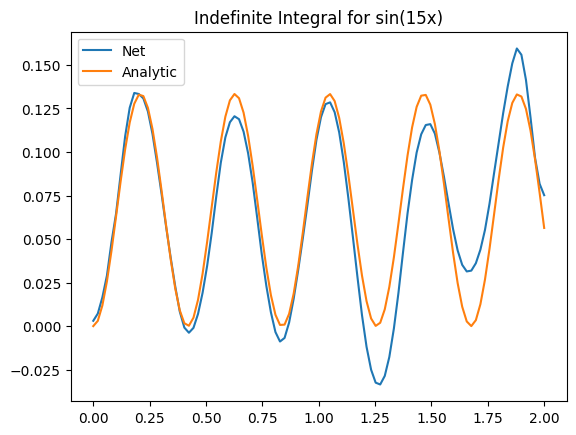

In [19]:
a = 15

x = torch.linspace(0,2,100)
dy = torch.sin(a*x)
dy_in = dy.unsqueeze(0).unsqueeze(1)
x_in = x.unsqueeze(0).unsqueeze(-1)
out_true = -1/a*(torch.cos(a*x)-1)
-(torch.cos(a*x)-1)
with torch.no_grad():
    out = Onet.cpu()(x_in,dy_in).squeeze()

print(out.shape)

plt.plot(x,out,label = 'Net')
plt.plot(x,out_true,label = 'Analytic')
plt.legend(loc='upper left')
plt.title(f'Indefinite Integral for sin({a}x)')
plt.savefig(f'a_{a}.png')
plt.show()